# VOLATILITY IN STOCK MARKET INDICES
## Introduction to Programming and Numerical Analysis - Spring 2020 - Project 1: Data analysis

In this project we fetch daily data for the Nasdaq Composite, Nikkei 225 and OMX C20 indices and use them to perform a descriptive analysis of stock market volatility from 2000 to today. First, we read in and clean the data. Next, we use the concatenate and join functions to compile the data in a single DataFrame. Then, we compute log returns and analyse these through descriptive statistics and (interactive) visualisations. Finally, we account for some real world events, which can be drivers of increased volatility in given periods. 

**Team:** Kongerækken

**Members:** Frederik Degn Pedersen (qwn116) & Christian Brauer Johanssen (sjk185)

**Imports and set magics:**

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
plt.style.use('seaborn-whitegrid')

import pydst #install with pip install pydst
import datetime
import quandl #install with pip install quandl

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#import dataproject

/Users/FrederikP/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Read and clean data for stock market indices
In this section, we first import data for the Nasdaq Composite and Nikkei 225 indices using the FRED API, and OMX C20 data using the Qandl API. Because the Quandl time series only stretches back to late 2008 (when Nasdaq aqcuired Københavns Fondsbørs), we complement the series with additional data from Statistics Denmark. Next, we clean and merge the datasets into a single DataFrame to be used for later analysis.

## FRED Data

In [2]:
# set start and end dates
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2020,4,6)

# read in data
stock_indices = pandas_datareader.data.DataReader(['NASDAQCOM', 'NIKKEI225'], 'fred', start, end)

# reset index
stock_indices.reset_index(inplace=True)

# rename columns
stock_indices.rename(columns = {'DATE':'date','NASDAQCOM':'nasdaq','NIKKEI225':'nikkei'}, inplace=True)

# show head
stock_indices.head()

,date,nasdaq,nikkei
0,2000-01-03,4131.15,NaN
1,2000-01-04,3901.69,19002.86
2,2000-01-05,3877.54,18542.55
3,2000-01-06,3727.13,18168.27
4,2000-01-07,3882.62,18193.41


In [3]:
# show info
stock_indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285 entries, 0 to 5284
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5285 non-null   datetime64[ns]
 1   nasdaq  5097 non-null   float64       
 2   nikkei  4965 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 124.0 KB


## Statistics Denmark Data
Our variable of interest, namely daily observations of the OMX C20 index is available from the table "RENTD".

In [4]:
# setup data loader in english
Dst = pydst.Dst(lang='en') 

# read in data, see appendix for details
c20_dst = Dst.get_data(table_id = 'DNRENTD', variables={'INSTRUMENT':['CKXNAA'], 'LAND':['DK'],
                                                        'OPGOER':['I'], 'TID':['*']})

# show head
c20_dst.head()

,INSTRUMENT,LAND,OPGOER,TID,INDHOLD
0,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D08,..
1,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D11,..
2,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D02,..
3,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D03,..
4,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D04,..


In [5]:
# rename column
c20_dst.rename(columns = {'INDHOLD':'omx_c20'}, inplace=True)

# fix date format
c20_dst['date'] = c20_dst.TID.str[:4]+'-'+c20_dst.TID.str[5:7]+'-'+c20_dst.TID.str[-2:]
c20_dst['date'] = pd.to_datetime(c20_dst['date'])

# sort by 'date'
c20_dst = c20_dst.sort_values(['date'])

# drop missing values and reset index
c20_dst = c20_dst[c20_dst['omx_c20'] != '..']
c20_dst.reset_index(inplace=True)
c20_dst.head()

,index,INSTRUMENT,LAND,OPGOER,TID,omx_c20,date
0,7911,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D03,109.1900,1994-01-03
1,657,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D04,109.8500,1994-01-04
2,658,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D05,110.1700,1994-01-05
3,659,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D06,109.7900,1994-01-06
4,660,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D07,109.0600,1994-01-07


In [6]:
# drop irrelevant columns
drop_these = ['index', 'INSTRUMENT', 'LAND', 'OPGOER', 'index','TID']
c20_dst.drop(drop_these, axis=1, inplace=True)

#order columns
cols = ['date']  + [col for col in c20_dst if col != 'date']
c20_dst = c20_dst[cols]

# change type to float
c20_dst['omx_c20'] = pd.to_numeric(c20_dst['omx_c20'], errors='coerce')

# drop dates before y2k
# a) find 
c20_dst.loc[c20_dst['date'] == '1999-12-31'] # index is 1509

# b) slice index of last trading day before y2k
c20_dst = c20_dst.iloc[1510:]

In [7]:
# show DataFrame
c20_dst

,date,omx_c20
1510,2000-01-03,260.92
1511,2000-01-04,252.78
1512,2000-01-05,246.98
1513,2000-01-06,249.47
1514,2000-01-07,251.79
...,...,...
4744,2012-11-26,487.22
4745,2012-11-27,488.88
4746,2012-11-28,486.44
4747,2012-11-29,490.77


In [8]:
# show info
c20_dst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 1510 to 4748
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3239 non-null   datetime64[ns]
 1   omx_c20  3239 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.7 KB


## Quandl Data

In [12]:
# fetching c20 data from quandl
c20_qua = quandl.get('NASDAQOMX/OMXC20',api_key="LnLRssZkxJ2_7zzxxaBs")

# drop irrelevant variables
drop_them = ['High', 'Low', 'Total Market Value', 'Dividend Market Value']
c20_qua.drop(drop_them,axis=1,inplace=True)

# reset index and rename columns
c20_qua.reset_index(inplace=True)
c20_qua.rename(columns={'Index Value':'omx_c20','Trade Date':'date'},inplace=True)

# show dataframe
c20_qua

,date,omx_c20
0,2008-11-17,262.89
1,2008-11-18,259.09
2,2008-11-19,249.53
3,2008-11-20,236.79
4,2008-11-24,245.91
...,...,...
2816,2020-03-30,1055.97
2817,2020-03-31,1073.74
2818,2020-04-01,1074.05
2819,2020-04-02,1064.83


In [13]:
# show info
c20_qua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821 entries, 0 to 2820
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2821 non-null   datetime64[ns]
 1   omx_c20  2818 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.2 KB


# Merge datasets into single DataFrame
First we drop observations post 2008-11-16 in the DataFrame from Statistics Denmark to make sure we have no overlapping entries. Then, we first concatenate the data Statistics Denmark and Quandl. Finally, we merge the C20 data onto the stock_indices DataFrame using an outer join. We also provide a Venn diagram to illustrate the outer join proces.

In [17]:
# concatenate Quandl and Statistics Denmark data
c20 = pd.concat([c20_dst,c20_qua])
c20.drop_duplicates(subset=None,keep="first",inplace=True)
c20

,date,omx_c20
1510,2000-01-03,260.92
1511,2000-01-04,252.78
1512,2000-01-05,246.98
1513,2000-01-06,249.47
1514,2000-01-07,251.79
...,...,...
2816,2020-03-30,1055.97
2817,2020-03-31,1073.74
2818,2020-04-01,1074.05
2819,2020-04-02,1064.83


In [18]:
# show info
c20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5049 entries, 1510 to 2820
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5049 non-null   datetime64[ns]
 1   omx_c20  5046 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.3 KB


In [19]:
# merge c20 data onto fred data using outer join
stock_indices = pd.merge(stock_indices,c20,on=['date'],how='outer')
#stock_indices[c20] = pd.to_numeric(stock_indices[c20], errors='coerce')
stock_indices

,date,nasdaq,nikkei,omx_c20
0,2000-01-03,4131.150000,NaN,260.92
1,2000-01-04,3901.690000,19002.86,252.78
2,2000-01-05,3877.540000,18542.55,246.98
3,2000-01-06,3727.130000,18168.27,249.47
4,2000-01-07,3882.620000,18193.41,251.79
...,...,...,...,...
5280,2020-03-30,7774.152000,19084.97,1055.97
5281,2020-03-31,7700.098000,18917.01,1073.74
5282,2020-04-01,7360.582000,18065.41,1074.05
5283,2020-04-02,7487.313000,17818.72,1064.83


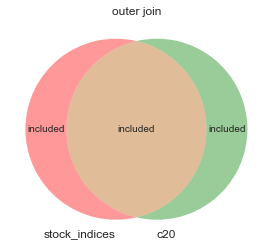

In [23]:
# venn diagram
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('stock_indices', 'c20'))
v.get_label_by_id('100').set_text('included')
v.get_label_by_id('010').set_text('included')
v.get_label_by_id('110').set_text('included')
plt.title('outer join')
plt.show()

# Analysis
To get a feeling of the data at hand, we begin by graphing the raw indices.

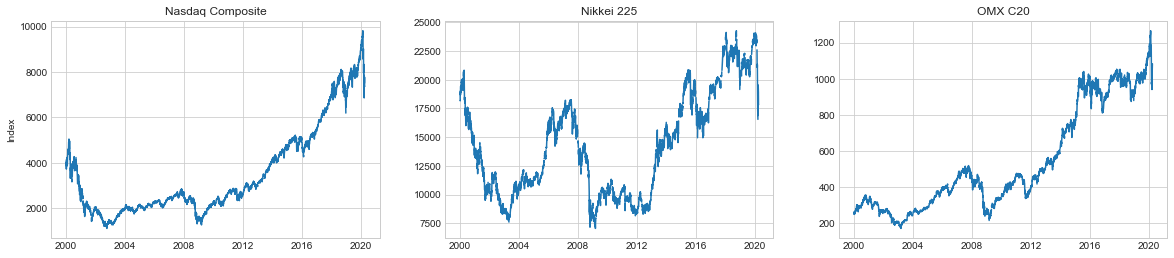

In [25]:
# graph raw indices 
fig = plt.figure(figsize=(20,4))

ax_left = fig.add_subplot(1,3,1)

ax_left.plot(stock_indices.date,stock_indices.nasdaq)
ax_left.set_title('Nasdaq Composite')
ax_left.set_ylabel('Index')
ax_left.grid(True)

ax_mid = fig.add_subplot(1,3,2)

ax_mid.plot(stock_indices.date,stock_indices.nikkei)
ax_mid.set_title('Nikkei 225')
ax_mid.grid(True)
            
ax_right = fig.add_subplot(1,3,3)

ax_right.plot(stock_indices.date,stock_indices.omx_c20)
ax_right.set_title('OMX C20')
ax_right.grid(True)

## Log Returns and Summary Statistics
Because the indices are not normalised (different base year, not necessarily indexed to 100 in the baseyear, ect.), it is not straightforward to make comparisons between them. Therefore, we calculate the log returns as follows:


The log returns are (approximately) equal to the daily return in percent. As we now measure the ***relative returns***, comparisons are now possible. Thus we compute the mean return, the standard deviation, and the min and max observations for each index in each year.

In [26]:
#calculate log returns
indices = ['nasdaq','nikkei', 'omx_c20']
for i in indices:
    stock_indices[f'log_returns_{i}']= np.log(stock_indices[i]).diff()*100

In [27]:
# DataFrames with descriptive stats by year and month

#  extract year/month variable from datetime variable for statistics
stock_indices['year'], stock_indices['month'] = stock_indices['date'].dt.year, stock_indices['date'].dt.month

# setup empty DataFrame
desc_stat_y = pd.DataFrame()
desc_stat_m = pd.DataFrame()

# append columns to desc_stat
for i in indices:
    desc_stat_y[f'mean_{i}']= stock_indices.groupby('year')[f'log_returns_{i}'].mean()
    desc_stat_y[f'std_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].std()
    desc_stat_y[f'min_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].min()
    desc_stat_y[f'max_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].max()

for i in indices:
    desc_stat_m[f'mean_{i}']= stock_indices.groupby('month')[f'log_returns_{i}'].mean()
    desc_stat_m[f'std_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].std()
    desc_stat_m[f'min_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].min()
    desc_stat_m[f'max_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].max()
    
desc_stat_y

,mean_nasdaq,std_nasdaq,min_nasdaq,max_nasdaq,mean_nikkei,std_nikkei,min_nikkei,max_nikkei,mean_omx_c20,std_omx_c20,min_omx_c20,max_omx_c20
year,,,,,,,,,,,,
2000,-0.223634,3.040178,-10.168411,9.963643,-0.144391,1.413980,-7.233984,3.688680,0.058271,1.371281,-4.655913,3.385079
2001,0.018251,2.662478,-6.511092,13.254645,-0.145368,1.778012,-6.864457,4.785591,-0.074352,1.269312,-3.944924,3.315674
2002,-0.140102,2.148023,-4.268674,7.493773,-0.121180,1.584970,-4.104463,5.735232,-0.126513,1.558901,-5.592228,4.969850
2003,0.108891,1.363760,-3.730166,4.697792,0.010400,1.429745,-5.225837,3.325562,0.074013,1.128482,-3.266704,3.643380
2004,0.036612,1.071422,-2.552371,2.976501,0.049882,1.128903,-4.965470,2.764005,0.057384,0.757428,-3.451160,2.105019
2005,0.003338,0.784713,-2.079413,2.510342,0.096282,0.837941,-3.875580,2.206586,0.112608,0.830818,-2.834565,2.717106
2006,0.051367,0.880156,-2.378830,2.918396,0.044059,1.249234,-4.230414,3.522034,0.063378,0.966379,-4.165079,2.562359
2007,0.019013,1.110136,-3.935871,3.405569,-0.084207,1.163116,-5.569546,3.603123,0.014692,1.118625,-4.392061,3.745180
2008,-0.212372,2.616212,-9.587690,11.159442,-0.322277,2.787078,-12.111026,9.494147,-0.297121,2.439898,-11.723193,9.496355


In [28]:
desc_stat_m

,mean_nasdaq,std_nasdaq,min_nasdaq,max_nasdaq,mean_nikkei,std_nikkei,min_nikkei,max_nikkei,mean_omx_c20,std_omx_c20,min_omx_c20,max_omx_c20
month,,,,,,,,,,,,
1,0.028038,1.619919,-6.402051,13.254645,-0.073334,1.443609,-5.815688,5.710406,0.043071,1.173532,-5.575847,5.697046
2,-0.012927,1.353052,-5.124567,3.825103,0.000016,1.394205,-5.555174,6.911311,0.096920,1.310499,-6.780968,5.142810
3,0.004513,1.976347,-13.149032,8.934618,-0.032959,1.783731,-11.153434,7.731370,-0.011167,1.291417,-7.820803,4.875738
4,0.058293,1.792421,-10.168411,8.545415,0.039615,1.349837,-7.233984,4.310375,0.072393,1.289639,-4.655913,5.111416
5,-0.027414,1.435013,-6.118230,7.493773,-0.059539,1.286393,-7.597361,2.982411,0.049601,1.132139,-4.228675,6.167653
6,0.020429,1.333921,-4.202315,6.245505,0.020657,1.388982,-8.252932,4.825705,-0.046697,1.185761,-3.809050,3.309100
7,0.035951,1.363109,-4.777044,5.632569,-0.032107,1.196500,-3.472313,3.906545,0.084921,1.099921,-5.592228,4.969850
8,0.002335,1.423538,-7.148909,5.159185,-0.057086,1.316271,-5.569546,3.765184,0.021409,1.263712,-4.951225,3.745180
9,-0.064414,1.454373,-9.587690,5.216420,-0.018757,1.481745,-6.864457,7.426170,-0.092450,1.292159,-5.448375,6.591694


## Summary Statistics Plots
While the above DataFrames are good for looking an exact value in a given year, it is not a good tool for comparison across stock markets or time. Therefore we provide interactive plots below, where the statistic can be selected and compared.

In [31]:
col_list = list(desc_stat_y.columns)
year_list = [2000 + i for i in range(0,21,1)]

def update_plot(stat1,stat2,stat3):
    """
    This function is linked to ipy.widgets dropdowns and it replots the figure
    for the chosen descriptive statistics.
    
    """
    desc_stat_y.plot(y=[stat1,stat2,stat3],style='-o', figsize=(12,4), xticks=(range(2000,2021,2)));

stat1 = widgets.Dropdown(description='Statistic #1',options=col_list)
stat2 = widgets.Dropdown(description='Statistic #2',options=col_list)
stat3 = widgets.Dropdown(description='Statistic #3',options=col_list)

widgets.interact(update_plot,stat1=stat1,stat2=stat2,stat3=stat3);


interactive(children=(Dropdown(description='Statistic #1', options=('mean_nasdaq', 'std_nasdaq', 'min_nasdaq',…

## Volatility Plots
Another way to get a visual impression of the volatility across time is to plot the log returns directly, which we do below.

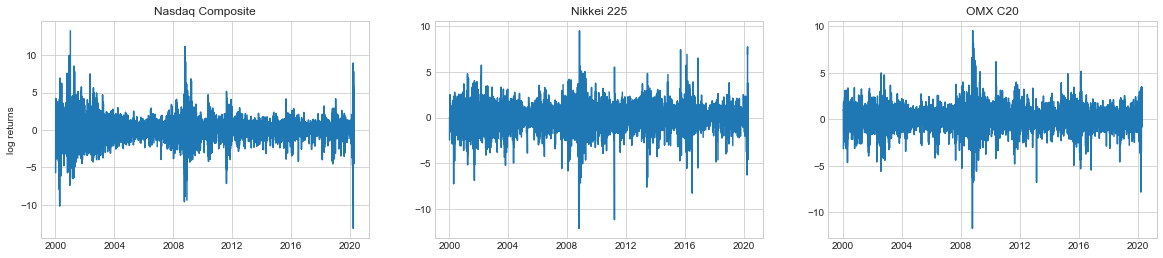

In [62]:
# create the figure
fig_vol = plt.figure(figsize=(20,4))

ax_left = fig.add_subplot(1,3,1)

ax_left.plot(stock_indices.date,stock_indices.log_returns_nasdaq)
ax_left.set_title('Nasdaq Composite')
ax_left.set_ylabel('log returns')
ax_left.grid(True)

ax_mid = fig.add_subplot(1,3,2)

ax_mid.plot(stock_indices.date,stock_indices.log_returns_nikkei)
ax_mid.set_title('Nikkei 225')
ax_mid.grid(True)
            
ax_right = fig.add_subplot(1,3,3)

ax_right.plot(stock_indices.date,stock_indices.log_returns_omx_c20)
ax_right.set_title('OMX C20')
ax_right.grid(True)

# Conclusion

In this assignment we chose to compare selected stock indices with daily observations from  2000-2020. Being longs stock has generally been very profitable during this period, which is is evident from looking at e.g. Nasdaq Composite or OMX C20 indices over time. An exception is the Japanese Nikkei that almost just recovered its 25 year slump before falling off a cliff due to the COVID-19 pandemic. This recent pandemic has stirred major uncertainty e.g. causing the single biggest daily meltdown in Nasdaq during our sample period of 13 around percent. 

Compared to Nikkei and especially OMX C20, the tech-heavy Nasdaq Composite also experienced highest volatility in the Dot-com bubble of 2000-2001. Relatively higher Dot-com and COVID-19 volatility in the Nasdaq Composite is evident from plotting the indices' yearly standard deviations against each other However, all indices saw major drawdowns during the GFC with Nikkei suffering the most dropping 32 percent. Despite the fact that returns on average were very low during bear markets in 2000-2002, 2008 and 2020 so far, these bear markets also provide(d) some of the biggest rallies with daily upsides well above 8 percent. These are glorious times for swing traders. 

# Annex - Finding the Right Key for Statistics Denmark's RENTD Table
To find the dictionary input for data extraction from Statistics Denmark, we first use the get_variables command to inspect the variables.
To find the correct key for the OMX C20 data, we print the full string entered in the 'values' column and 'INSTRUMENT' row.

In [55]:
# inspect variables of DNRENTD
omx_info = Dst.get_variables(table_id='DNRENTD')
omx_info

,id,text,elimination,time,values
0,INSTRUMENT,item,False,False,"[{'id': 'ODKNAA', 'text': 'The Nationalbanks o..."
1,LAND,country,True,False,"[{'id': 'DK', 'text': 'DK: Denmark'}]"
2,OPGOER,methodology,False,False,"[{'id': 'E', 'text': 'Daily interest rates (pe..."
3,Tid,time,False,True,"[{'id': '1983M05D10', 'text': '1983M05D10'}, {..."


In [ ]:
# Print full string to find the key for OMX C20
def print_full(x):
    pd.set_option('display.max_colwidth', -1)
    print(x)

x = omx_info.loc[omx_info['id'] == 'INSTRUMENT'], ['values']
print_full(x)